In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, \
LassoCV, ElasticNetCV, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import accuracy_score, r2_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import re
import scikitplot as skplt
import nltk
from imblearn.over_sampling import SMOTE

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## <font color = blue>Data Cleaning</font>

In [3]:
data = pd.read_csv('Jobstreet1.csv', encoding = 'utf-8')
data.head()

,Unnamed: 0,Experience,Location,Posting,Salary,Title
0,0,Min 2 years (Senior Executive),Singapore - East - MacPherson,$3-$4K basic + transport allowances + Variabl...,"SGD 3,000 - SGD 5,000",sales engineer ( m&e / data center / facility ...
1,1,Min 2 years (Junior Executive),Singapore - Across Singapore,Responsibilities:Oversees Systems Upgrade and...,"SGD 2,500 - SGD 5,000",data center engineer
2,2,Junior Executive,Singapore - Across Singapore - Singapore,Data Center Engineer The OpportunityAn opp...,"SGD 2,500 - SGD 3,500",data center engineer
3,3,Min 4 years (Senior Executive),Singapore - Central,Rapsys Technologies Pte Ltd Central Singapore...,Around expected salary,data engineer
4,4,Min 3 years (Senior Executive),Singapore - Central,Rapsys Technologies Pte Ltd Tampines Qualific...,Around expected salary,data engineer


In [4]:
# Column Unnamed: 0 is dropped 
data.drop(columns = ['Unnamed: 0'], inplace = True)

In [5]:
# A copy is created. Upon inspection, there are duplicates in the job postings. 
# Only the first is kept and the rest is dropped.
data1 = data.copy() 
data1.drop_duplicates(keep = 'first', inplace = True)

In [6]:
# Check data types
data1.dtypes

Experience    object
Location      object
Posting       object
Salary        object
Title         object
dtype: object

In [7]:
# Check data shape
data1.shape

(1647, 5)

In [8]:
# Upon inspection there are a few discrepancies in the Salary section.
# Any salary that is not disclosed is dropped.
# Same goes for salary that is not in SGD as well as what I felt as salaries
# provided might be a yearly range instead of monthly.
data1 = data1[(data1['Salary'] != 'Undisclosed') & (data1['Salary'] != 'USD 1,500 - USD 2,500') & \
              (data1['Salary'] != 'USD 4,500 - USD 7,500') & (data1['Salary'] != 'USD 4,500 - USD 8,500')\
              & (data1['Salary'] != 'SGD 90,000 - SGD 180,000') & (data1['Salary'] != 'SGD 50,000 - SGD 70,000')\
              & (data1['Salary'] != 'SGD 60,000 - SGD 70,000') & (data1['Salary'] != 'SGD 80,000 - SGD 130,000') \
             & (data1['Salary'] != 'SGD 50,000 - SGD 60,000') & (data1['Salary'] != 'SGD 60,000 - SGD 80,000')\
             & (data1['Salary'] != 'SGD 55,000 - SGD 65,000')]

In [9]:
data1.shape

(1519, 5)

In [10]:
# As I scrapped from jobstreet, some job salaries are labelled as around / below / above expected salary.
# Hence I manually input the range as 5000 / 4900 / 5100 respectively while the lower end range is 
# imputed with the median value (this is done below, In 23).
data1['Salary'] = data1['Salary'].map(lambda x:x.replace('Around expected salary', '2500 5000').replace('Below expected salary', '2500 4900').replace('Above expected salary', '2500 5100'))
data1.head

<bound method NDFrame.head of                           Experience  \
0     Min 2 years (Senior Executive)   
1     Min 2 years (Junior Executive)   
2                   Junior Executive   
3     Min 4 years (Senior Executive)   
4     Min 3 years (Senior Executive)   
5     Min 2 years (Junior Executive)   
6     Min 2 years (Junior Executive)   
7      Min 1 year (Junior Executive)   
8              Min 4 years (Manager)   
10    Min 5 years (Senior Executive)   
15    Min 2 years (Junior Executive)   
16    Min 2 years (Junior Executive)   
17    Min 2 years (Senior Executive)   
18    Min 2 years (Senior Executive)   
19     Min 1 year (Junior Executive)   
20    Min 3 years (Senior Executive)   
21    Min 2 years (Senior Executive)   
22    Min 3 years (Senior Executive)   
23       Min 4 years (Non-Executive)   
24             Min 5 years (Manager)   
25             Min 5 years (Manager)   
26    Min 5 years (Senior Executive)   
28         Min 3 years (Entry Level)   
29     Min

In [11]:
data1['Salary'] = data1['Salary'].apply(lambda x: x.replace(',', '').split())

In [12]:
data1['Salary'] = data1['Salary'].apply(lambda x: [i for i in x if i != 'SGD' and i != '-'])

In [13]:
data1['Salary'].head()

0    [3000, 5000]
1    [2500, 5000]
2    [2500, 3500]
3    [2500, 5000]
4    [2500, 5000]
Name: Salary, dtype: object

### <font color = blue>Feature Engineering and Data Cleaning</font>

In [14]:
data1['Low_End'] = data1['Salary'].apply(lambda x: x[0])
data1['High_End'] = data1['Salary'].apply(lambda x: x[1])

In [15]:
data1['Salary'] = data1['Salary'].apply(lambda x:'-'.join(x))

In [16]:
data1.head()

,Experience,Location,Posting,Salary,Title,Low_End,High_End
0,Min 2 years (Senior Executive),Singapore - East - MacPherson,$3-$4K basic + transport allowances + Variabl...,3000-5000,sales engineer ( m&e / data center / facility ...,3000,5000
1,Min 2 years (Junior Executive),Singapore - Across Singapore,Responsibilities:Oversees Systems Upgrade and...,2500-5000,data center engineer,2500,5000
2,Junior Executive,Singapore - Across Singapore - Singapore,Data Center Engineer The OpportunityAn opp...,2500-3500,data center engineer,2500,3500
3,Min 4 years (Senior Executive),Singapore - Central,Rapsys Technologies Pte Ltd Central Singapore...,2500-5000,data engineer,2500,5000
4,Min 3 years (Senior Executive),Singapore - Central,Rapsys Technologies Pte Ltd Tampines Qualific...,2500-5000,data engineer,2500,5000


In [17]:
data1.shape

(1519, 7)

In [19]:
# Feature Engineered lower end of the salary range 
data1['Low_End'] = pd.to_numeric(data1['Low_End'], errors = 'coerce')

In [20]:
# Feature Engineered higher end of the salary range
data1['High_End'] = pd.to_numeric(data1['High_End'], errors = 'coerce')
data1.head()

,Experience,Location,Posting,Salary,Title,Low_End,High_End
0,Min 2 years (Senior Executive),Singapore - East - MacPherson,$3-$4K basic + transport allowances + Variabl...,3000-5000,sales engineer ( m&e / data center / facility ...,3000,5000
1,Min 2 years (Junior Executive),Singapore - Across Singapore,Responsibilities:Oversees Systems Upgrade and...,2500-5000,data center engineer,2500,5000
2,Junior Executive,Singapore - Across Singapore - Singapore,Data Center Engineer The OpportunityAn opp...,2500-3500,data center engineer,2500,3500
3,Min 4 years (Senior Executive),Singapore - Central,Rapsys Technologies Pte Ltd Central Singapore...,2500-5000,data engineer,2500,5000
4,Min 3 years (Senior Executive),Singapore - Central,Rapsys Technologies Pte Ltd Tampines Qualific...,2500-5000,data engineer,2500,5000


In [21]:
# sorted the values to obtain median.
data1.sort_values(['Low_End', 'High_End'], ascending = [1,1])

,Experience,Location,Posting,Salary,Title,Low_End,High_End
1182,Min 2 years (Junior Executive),Singapore - Central,Job Description:Supports technical service ac...,1500-2000,technical support assistant engineer (1-year c...,1500,2000
1376,Min 1 year (Junior Executive),Singapore - West - Tuas,"Costing & estimation of switchboards, etc.Ass...",1500-3000,estimator engineer ( high voltage electrical),1500,3000
376,Min 1 year (Junior Executive),Singapore - Central,Responsibles:Receive inquiries from customers...,1600-2000,**sales coordinator [tuas | $2000 | training p...,1600,2000
571,Min 2 years (Non-Executive),Singapore - Across Singapore - Depot Road,Job Descriptions : Perform site surveys w...,1600-2600,project engineer (ref : ics/isd/slk),1600,2600
275,Min 1 year (Junior Executive),Multiple work locations\r\n\r\n\r\n\r\n\t\t\t\...,Well Established CompanyTraining is provided ...,1600-3000,project/field engineers x 3 (training is provi...,1600,3000
1190,Min 1 year (Junior Executive),Multiple work locations\r\n\r\n\r\n\r\n\t\t\t\...,Well Established CompanyTraining is providedL...,1600-3000,project/field engineers (training is provided)...,1600,3000
1508,Min 1 year (Junior Executive),Multiple work locations\r\n\r\n\r\n\r\n\t\t\t\...,Well Established CompanyTraining is providedL...,1600-3000,"project/field engineers (training is provided,...",1600,3000
1356,Entry Level,Singapore - Central - Bukit Merah,Responsibilities:\r\n\r\nCoordinate sales tea...,1700-2200,sales coordinator,1700,2200
141,Entry Level,Singapore - Central,Location: BedokWorking Hours: Monday - Friday...,1700-2500,"associate engineer, it support / data migratio...",1700,2500
739,Entry Level,Multiple work locations\r\n\r\n\r\n\r\n\t\t\t\...,Well Established Company Training is provided...,1700-3000,"field engineers (project, training is provided...",1700,3000


In [22]:
data1.describe()

,Low_End,High_End
count,1519.000000,1519.000000
mean,3191.383805,5109.764319
std,1152.240349,1516.953429
min,1500.000000,2000.000000
25%,2500.000000,4500.000000
50%,2500.000000,5000.000000
75%,4000.000000,5500.000000
max,12000.000000,15000.000000


In [23]:
print ('Median for low-end salary = ', data1['Low_End'].median())
print ('Median for high-end salary = ', data1['High_End'].median())

Median for low-end salary =  2500.0
Median for high-end salary =  5000.0


In [24]:
# Feature engineered
# According to median values, if salary is above or equals to SGD 5000, it is considered as high. 
# While low salary is denoted by 0 and less than SGD 5000.
def func (x):
    if x >= 5000:
        return float (1)
    else:
        return float (0)
    
data1['High or Low Salary'] = data1['High_End'].map(func)
data1.head()

,Experience,Location,Posting,Salary,Title,Low_End,High_End,High or Low Salary
0,Min 2 years (Senior Executive),Singapore - East - MacPherson,$3-$4K basic + transport allowances + Variabl...,3000-5000,sales engineer ( m&e / data center / facility ...,3000,5000,1.0
1,Min 2 years (Junior Executive),Singapore - Across Singapore,Responsibilities:Oversees Systems Upgrade and...,2500-5000,data center engineer,2500,5000,1.0
2,Junior Executive,Singapore - Across Singapore - Singapore,Data Center Engineer The OpportunityAn opp...,2500-3500,data center engineer,2500,3500,0.0
3,Min 4 years (Senior Executive),Singapore - Central,Rapsys Technologies Pte Ltd Central Singapore...,2500-5000,data engineer,2500,5000,1.0
4,Min 3 years (Senior Executive),Singapore - Central,Rapsys Technologies Pte Ltd Tampines Qualific...,2500-5000,data engineer,2500,5000,1.0


In [25]:
# To clean experience column
data1['Experience'].unique()

array(['Min 2 years (Senior Executive)', 'Min 2 years (Junior Executive)',
       'Junior Executive', 'Min 4 years (Senior Executive)',
       'Min 3 years (Senior Executive)', 'Min 1 year (Junior Executive)',
       'Min 4 years (Manager)', 'Min 5 years (Senior Executive)',
       'Min 4 years (Non-Executive)', 'Min 5 years (Manager)',
       'Min 3 years (Entry Level)', 'Min 3 years (Manager)',
       'Entry Level', 'Min 1 year (Entry Level)',
       'Min 3 years (Junior Executive)', 'Min 7 years (Senior Executive)',
       'Min 4 years (Junior Executive)', 'Min 10 years (Senior Manager)',
       'Min 6 years (Manager)', 'Min 1 year (Non-Executive)',
       'Min 6 years (Senior Executive)', 'Min 2 years (Manager)',
       'Min 10 years (Manager)', 'Min 8 years (Manager)',
       'Min 8 years (Senior Executive)', 'Min 1 year (Senior Executive)',
       'Min 5 years (Junior Executive)', 'Min 6 years (Senior Manager)',
       'Min 7 years (Manager)', 'Min 2 years (Non-Executive)',
     

In [26]:
# Feature engineered
# to obtain the level of the position: junior, senior, entry, executive or manager
data1['Level'] = data1['Experience'].str.extract('([A-Z]\w{3,})', expand=True)

# the years of experience was extracted and placed into a new column
data1['Yrs Experience'] = data1['Experience'].str.extract('(\d)', expand=True)
data1['Yrs Experience'] = data1['Yrs Experience'].fillna(0)
# data1['Level']

In [27]:
data1.shape

(1519, 10)

In [28]:
data1.head()

,Experience,Location,Posting,Salary,Title,Low_End,High_End,High or Low Salary,Level,Yrs Experience
0,Min 2 years (Senior Executive),Singapore - East - MacPherson,$3-$4K basic + transport allowances + Variabl...,3000-5000,sales engineer ( m&e / data center / facility ...,3000,5000,1.0,Senior,2
1,Min 2 years (Junior Executive),Singapore - Across Singapore,Responsibilities:Oversees Systems Upgrade and...,2500-5000,data center engineer,2500,5000,1.0,Junior,2
2,Junior Executive,Singapore - Across Singapore - Singapore,Data Center Engineer The OpportunityAn opp...,2500-3500,data center engineer,2500,3500,0.0,Junior,0
3,Min 4 years (Senior Executive),Singapore - Central,Rapsys Technologies Pte Ltd Central Singapore...,2500-5000,data engineer,2500,5000,1.0,Senior,4
4,Min 3 years (Senior Executive),Singapore - Central,Rapsys Technologies Pte Ltd Tampines Qualific...,2500-5000,data engineer,2500,5000,1.0,Senior,3


In [29]:
# To clean location
data1['Location'].unique()

array(['Singapore - East - MacPherson', 'Singapore - Across Singapore',
       'Singapore - Across Singapore - Singapore', 'Singapore - Central',
       'Singapore - West - Jurong East',
       'Singapore - North-East - Serangoon',
       'Singapore - East - Paya Lebar - 6 Tai Seng Link',
       'Singapore - Central - Kallang - Kallang',
       'Singapore - Central - Downtown Core - Tanjong Pagar',
       'Singapore - East', 'Singapore - West', 'Singapore - North-East',
       'Singapore - East - Paya Lebar', 'Singapore - East - Kaki Bukit',
       'Singapore - West - Jurong East - Teban Garden Crescent',
       'Singapore - North-East - Ang Mo Kio - Yio Chu Kang',
       'Malaysia - Kuala Lumpur - Menara AIA Cap Square',
       'Singapore - Across Singapore - Guoco Tower, Singapore',
       'Singapore - Across Singapore - Site Locations @ Jurong /AMK/Changi /Shenton Way',
       'Multiple work locations\r\n\r\n\r\n\r\n\t\t\t\tSingapore - East\t\t\t\r\n\r\n\t\t\t\tSingapore - Central',

In [30]:
data1['Location'] = data1['Location'].apply(lambda x: x.replace \
                                            ('locations\r\n\r\n\r\n\r\n\t\t\t\tSingapore', 'locations').replace\
                                            ('\t\t\t\r\n\r\n\t\t\t\tSingapore', ' '))

In [31]:
data1 = data1[data1['Location'].str.contains ('singapore', flags=re.IGNORECASE, regex=True)]

In [32]:
data1['Location'].unique()

array(['Singapore - East - MacPherson', 'Singapore - Across Singapore',
       'Singapore - Across Singapore - Singapore', 'Singapore - Central',
       'Singapore - West - Jurong East',
       'Singapore - North-East - Serangoon',
       'Singapore - East - Paya Lebar - 6 Tai Seng Link',
       'Singapore - Central - Kallang - Kallang',
       'Singapore - Central - Downtown Core - Tanjong Pagar',
       'Singapore - East', 'Singapore - West', 'Singapore - North-East',
       'Singapore - East - Paya Lebar', 'Singapore - East - Kaki Bukit',
       'Singapore - West - Jurong East - Teban Garden Crescent',
       'Singapore - North-East - Ang Mo Kio - Yio Chu Kang',
       'Singapore - Across Singapore - Guoco Tower, Singapore',
       'Singapore - Across Singapore - Site Locations @ Jurong /AMK/Changi /Shenton Way',
       'Singapore - Central - Downtown Core',
       'Singapore - Central - Others - Cecil Street',
       'Singapore - North-East - Ang Mo Kio',
       'Singapore - West -

In [33]:
data1 = data1[(data1['Location'] != 'Malaysia - Johor - JB/SINGAPORE')]
data1.shape

(1460, 10)

In [34]:
data1['Location'] = data1['Location'].apply(lambda x: x.split())
data1['Location'] = data1['Location'].apply(lambda x: [i for i in x if i != '-'
                                                       and i != 'Multiple' and i !='work'])

# Feature engineered: Extracting specific area of Singapore where the job is
data1['New_Loc'] = data1['Location'].apply(lambda x: x[1])
data1.head()

,Experience,Location,Posting,Salary,Title,Low_End,High_End,High or Low Salary,Level,Yrs Experience,New_Loc
0,Min 2 years (Senior Executive),"[Singapore, East, MacPherson]",$3-$4K basic + transport allowances + Variabl...,3000-5000,sales engineer ( m&e / data center / facility ...,3000,5000,1.0,Senior,2,East
1,Min 2 years (Junior Executive),"[Singapore, Across, Singapore]",Responsibilities:Oversees Systems Upgrade and...,2500-5000,data center engineer,2500,5000,1.0,Junior,2,Across
2,Junior Executive,"[Singapore, Across, Singapore, Singapore]",Data Center Engineer The OpportunityAn opp...,2500-3500,data center engineer,2500,3500,0.0,Junior,0,Across
3,Min 4 years (Senior Executive),"[Singapore, Central]",Rapsys Technologies Pte Ltd Central Singapore...,2500-5000,data engineer,2500,5000,1.0,Senior,4,Central
4,Min 3 years (Senior Executive),"[Singapore, Central]",Rapsys Technologies Pte Ltd Tampines Qualific...,2500-5000,data engineer,2500,5000,1.0,Senior,3,Central


In [35]:
# Inspect that the specific areas have been extracted from the job's initial Location column
data1.groupby(data1['New_Loc']).sum()

,Low_End,High_End,High or Low Salary
New_Loc,,,
Across,787712,1310924,154.0
Central,2118850,3215450,363.0
East,406600,658400,72.0
North,189850,310758,28.0
North-East,317000,542200,62.0
North-West,4000,5000,1.0
Singapore,11000,19000,3.0
West,849000,1408700,130.0


In [36]:
data1[data1['New_Loc'] == 'Singapore']

,Experience,Location,Posting,Salary,Title,Low_End,High_End,High or Low Salary,Level,Yrs Experience,New_Loc
243,Min 3 years (Senior Executive),"[Across, Singapore]",Sr / Lead Design Engineer (Test Development O...,2500-5000,sr / lead design engineer (test development op...,2500,5000,1.0,Senior,3,Singapore
807,Min 2 years (Senior Executive),"[Across, Singapore]",Responsibilities: • Participate in the design...,4000-8000,devops engineer,4000,8000,1.0,Senior,2,Singapore
1588,Min 3 years (Junior Executive),"[Across, Singapore]",✅ Location: West✅ Working hours: 9am - 6pm✅ I...,4500-6000,manufacturing integration engineer (mnc / west),4500,6000,1.0,Junior,3,Singapore


In [37]:
# replace Singapore with Across (by this means the job would require the individual to travel around
# Singapore), and the rest would be the name of the places without the hyphens.
data1['New_Loc'] = data1['New_Loc'].apply(lambda x: x.replace('Singapore', 'Across')
                                          .replace('North-East', 'NorthEast')
                                          .replace('North-West', 'NorthWest'))

In [38]:
# Check again that labelling is done appropriately
data1.groupby(data1['New_Loc']).sum()

,Low_End,High_End,High or Low Salary
New_Loc,,,
Across,798712,1329924,157.0
Central,2118850,3215450,363.0
East,406600,658400,72.0
North,189850,310758,28.0
NorthEast,317000,542200,62.0
NorthWest,4000,5000,1.0
West,849000,1408700,130.0


In [39]:
# Feature engineered: To label the job titles in category deemed fit for each respectively.
def cont(Name):
    if 'engineer' in Name:
        return 'Engineer'
    if 'data scientist' in Name:
        return 'Data Scientist'
    if 'research' in Name:
        return 'Research'
    if 'scientist' in Name:
        return 'Research'
    if 'sales' in Name:
        return 'Sales'
    if 'sale' in Name:
        return 'Sales'
    return 'Others'

In [40]:
data1['Category'] = data1['Title'].apply(cont)
data1.head()

,Experience,Location,Posting,Salary,Title,Low_End,High_End,High or Low Salary,Level,Yrs Experience,New_Loc,Category
0,Min 2 years (Senior Executive),"[Singapore, East, MacPherson]",$3-$4K basic + transport allowances + Variabl...,3000-5000,sales engineer ( m&e / data center / facility ...,3000,5000,1.0,Senior,2,East,Engineer
1,Min 2 years (Junior Executive),"[Singapore, Across, Singapore]",Responsibilities:Oversees Systems Upgrade and...,2500-5000,data center engineer,2500,5000,1.0,Junior,2,Across,Engineer
2,Junior Executive,"[Singapore, Across, Singapore, Singapore]",Data Center Engineer The OpportunityAn opp...,2500-3500,data center engineer,2500,3500,0.0,Junior,0,Across,Engineer
3,Min 4 years (Senior Executive),"[Singapore, Central]",Rapsys Technologies Pte Ltd Central Singapore...,2500-5000,data engineer,2500,5000,1.0,Senior,4,Central,Engineer
4,Min 3 years (Senior Executive),"[Singapore, Central]",Rapsys Technologies Pte Ltd Tampines Qualific...,2500-5000,data engineer,2500,5000,1.0,Senior,3,Central,Engineer


In [41]:
# Check the multi-class 
data1['Category'].value_counts()

Engineer          1289
Sales               71
Data Scientist      62
Research            21
Others              17
Name: Category, dtype: int64

In [172]:
# check = ['PHD', 'phd', 'PhD', 'Bachelor', "Bachelor's", 'Diploma', 'Computer Science', \
#          'Computer Vision', 'Science', 'Master', "Master's", 'Data Science', 'Computing', \
#          'Computational Biology', 'Statistics', 'Applied Maths', 'Applied Statistics', \
#         'Applied Mathematics']
data1.loc[data1['Posting'].str.contains('PhD', 'phd'), 'Education'] = 'PhD'
data1.loc[data1['Posting'].str.contains("Bachelor's"), 'Education'] = "Bachelor's"
data1.loc[data1['Posting'].str.contains('Masters'), 'Education'] = "Master's"
data1.loc[data1['Posting'].str.contains('Diploma'), 'Education'] = "Diploma"
data1.loc[data1['Posting'].str.contains('data science'), 'Education'] = "Data Science Experience"
data1.loc[data1['Posting'].str.contains('Data Science'), 'Education'] = "Data Science Experience"
data1.loc[data1['Posting'].str.contains("Computer Science"), 'Education'] = "Comp Science Degree"
data1.loc[data1['Posting'].str.contains('Statistics', 'Applied Statistics'), 'Education'] = 'Stats Degree'
data1.loc[data1['Posting'].str.contains("Computer Vision"), 'Education'] = "Comp Vision"
data1.loc[data1['Posting'].str.contains("Computing"), 'Education'] = "Computing"
data1.loc[data1['Posting'].str.contains("Engineering"), 'Education'] = "Engineering"
data1.loc[data1['Posting'].str.contains("working experience"), 'Education'] = "Working Experience"

In [173]:
data1

,Experience,Posting,Title,Low_End,High_End,High or Low Salary,Level,Yrs Experience,New_Loc,Category,Education
0,Min 2 years (Senior Executive),$3-$4K basic + transport allowances + Variabl...,sales engineer ( m&e / data center / facility ...,3000,5000,1.0,Senior,2,East,Engineer,NaN
1,Min 2 years (Junior Executive),Responsibilities:Oversees Systems Upgrade and...,data center engineer,2500,5000,1.0,Junior,2,Across,Engineer,Working Experience
2,Junior Executive,Data Center Engineer The OpportunityAn opp...,data center engineer,2500,3500,0.0,Junior,0,Across,Engineer,Engineering
3,Min 4 years (Senior Executive),Rapsys Technologies Pte Ltd Central Singapore...,data engineer,2500,5000,1.0,Senior,4,Central,Engineer,Engineering
4,Min 3 years (Senior Executive),Rapsys Technologies Pte Ltd Tampines Qualific...,data engineer,2500,5000,1.0,Senior,3,Central,Engineer,Engineering
5,Min 2 years (Junior Executive),Job Description: Perform site surveys wit...,data network engineer (ics/esd/cwl),2500,3600,0.0,Junior,2,West,Engineer,Working Experience
6,Min 2 years (Junior Executive),Job Description : Perform site surveys wit...,data centre / it infrastructure engineer (ics/...,2500,3600,0.0,Junior,2,West,Engineer,Working Experience
7,Min 1 year (Junior Executive),Job Description:Work closely with software de...,data engineer - singaporeans only - exp in sql...,3000,4000,0.0,Junior,1,Central,Engineer,Engineering
8,Min 4 years (Manager),Star Asia Trading Pte. Ltd. is looking for a ...,data engineer,2500,5000,1.0,Manager,4,Central,Engineer,Working Experience
10,Min 5 years (Senior Executive),\r\nKey Responsibilities: \r\n\r\nAnalysis th...,automotive data science & application engineer,2500,5000,1.0,Senior,5,NorthEast,Engineer,Engineering


In [178]:
data1['Education'] = data1['Education'].fillna('unspecified')
data1.isnull().sum()

Experience            0
Posting               0
Title                 0
Low_End               0
High_End              0
High or Low Salary    0
Level                 0
Yrs Experience        0
New_Loc               0
Category              0
Education             0
dtype: int64

## <font color = blue>Data Visualization</font>

In [54]:
data1 = data1.drop(columns = ['Location', 'Salary'])

In [55]:
data1.describe()

,Low_End,High_End,High or Low Salary
count,1460.000000,1460.000000,1460.000000
mean,3208.227397,5116.734247,0.556849
std,1157.509237,1521.668529,0.496928
min,1500.000000,2000.000000,0.000000
25%,2500.000000,4500.000000,0.000000
50%,2500.000000,5000.000000,1.000000
75%,4000.000000,5500.000000,1.000000
max,12000.000000,15000.000000,1.000000


In [56]:
data1['Low_End'].mean()

3208.227397260274

In [57]:
data1.iloc[730:732,]

,Experience,Posting,Title,Low_End,High_End,High or Low Salary,Level,Yrs Experience,New_Loc,Category,Education
890,Min 2 years (Manager),Embark on a rewarding career with us and be e...,sales manager (networking/ home appliance/ iot...,2500,5000,1.0,Manager,2,East,Sales,Comp Science Degree
891,Min 2 years (Junior Executive),Job Description:• Understands corporate infor...,cybersecurity engineer - urgent,4000,4500,0.0,Junior,2,Central,Engineer,Comp Science Degree


C:\Users\syami\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


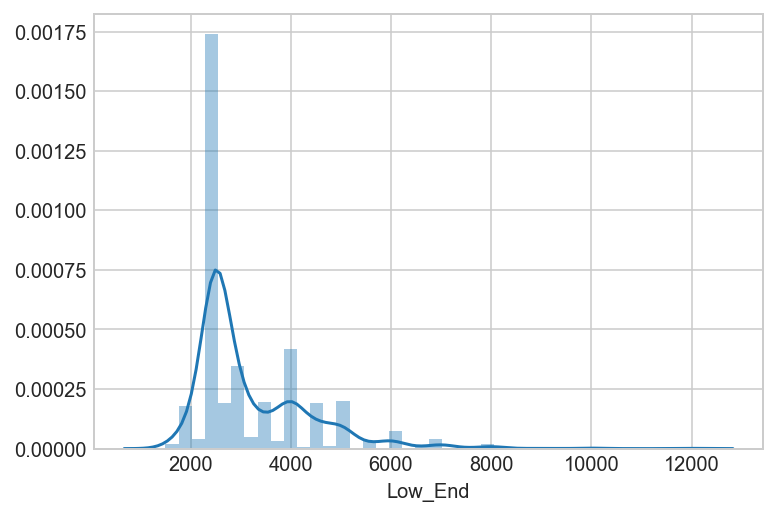

In [58]:
sns.distplot(data1['Low_End'])

C:\Users\syami\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


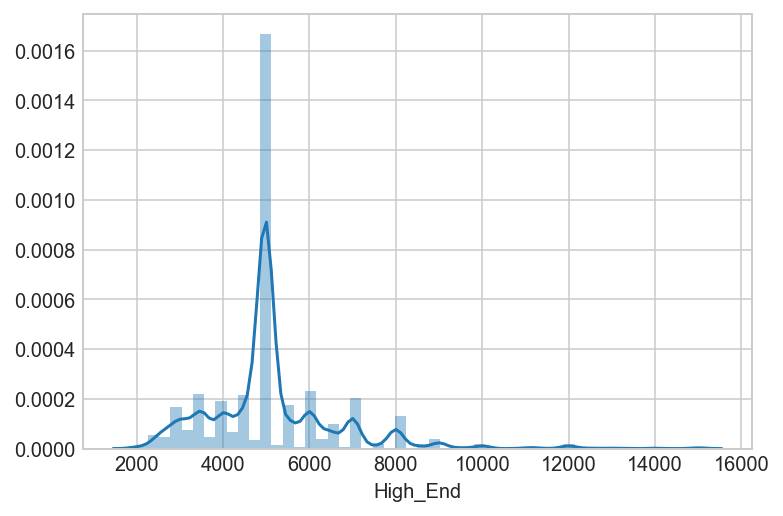

In [59]:
sns.distplot(data1['High_End'])

In [60]:
chart1 = data1.groupby('Level').sum()
chart1

,Low_End,High_End,High or Low Salary
Level,,,
Entry,326700,507250,16.0
Executive,112850,192000,10.0
Junior,1688000,2683358,198.0
Manager,284000,444000,65.0
Senior,2272462,3643824,524.0


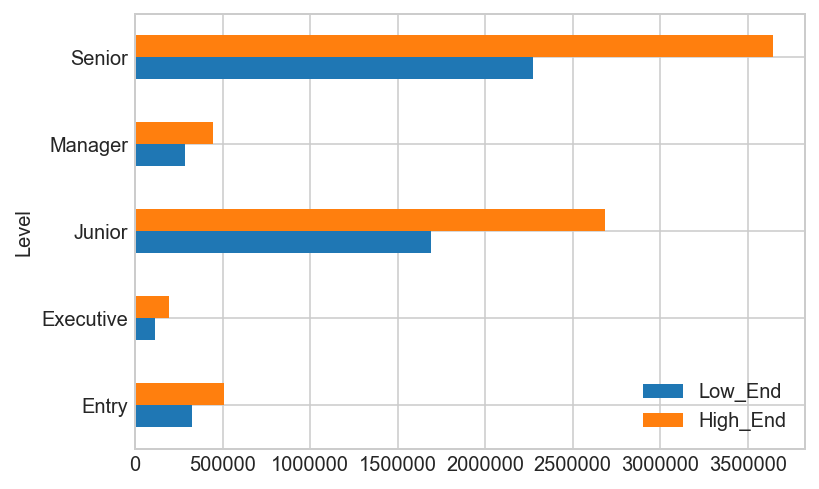

In [61]:
chart1[['Low_End', 'High_End']].plot(kind = 'barh')
# data1.plot(kind = 'barh', x = data1['High or Low Salary'], y = data1['Level'])

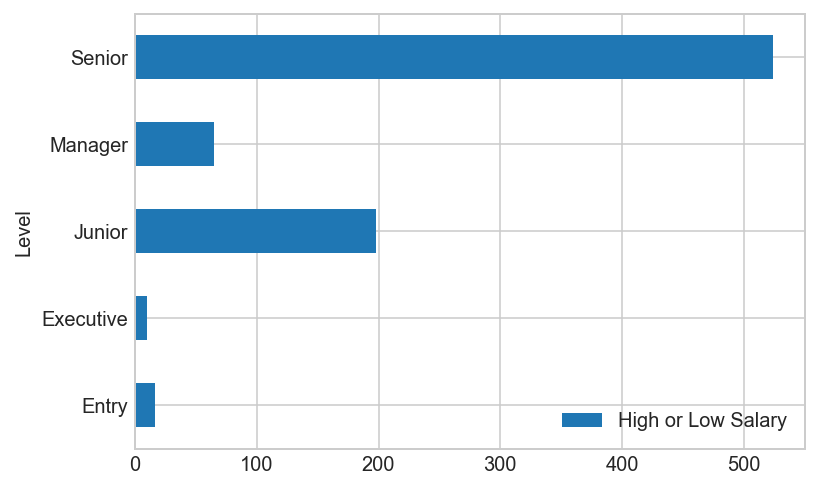

In [62]:
chart1[['High or Low Salary']].plot(kind = 'barh')

In [63]:
data1['High or Low Salary'].value_counts()

1.0    813
0.0    647
Name: High or Low Salary, dtype: int64

In [64]:
len(data1['High or Low Salary'])/2

730.0

### <font color = blue>Qn 1: To predict factors that would impact salary.
- Target variable is set as Low (< SGD 5000) and High (> SGD 5000)
- Feature used: Job Title (Raw). This is to mimic real-world data which might include words other than specifically a job title.
- Note: For this part 1 of qn 1, upsampling is **NOT** done.</font>

In [273]:
# Separate input features and targets
X = data1['Title']
y = data1['High or Low Salary']

# Split into train and test sets
X_train, X_test, y_train,y_test = train_test_split (X, y, test_size = 0.25, stratify = y)

In [274]:
# Bag of words, fit on X_train and transform on both X_train and X_test.
CV = CountVectorizer(stop_words = 'english', ngram_range = (1,2), binary = True)
CV.fit(X_train)
Xt_train = CV.transform (X_train)
Title_Train = pd.DataFrame(Xt_train.todense(), columns = CV.get_feature_names())
Title_Train.head()

,000,000 000,000 basic,000 central,000 civil,000 infrastructure,000 north,000 vb,03_180102,065,...,yishun,yishun 5days,yishun aac,yishun days,yr,yr contract,yr renewable,yrs,yrs exp,yrs urgent
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [275]:
Xt_test = CV.transform (X_test)
Title_Test = pd.DataFrame(Xt_test.todense(), columns = CV.get_feature_names())
Title_Test.head()

,000,000 000,000 basic,000 central,000 civil,000 infrastructure,000 north,000 vb,03_180102,065,...,yishun,yishun 5days,yishun aac,yishun days,yr,yr contract,yr renewable,yrs,yrs exp,yrs urgent
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### <font color = blue>Model 1: BernoulliNB with cross-val.</font>

In [74]:
bnb = BernoulliNB()
kf = KFold (n_splits = 5)
cv_score = cross_val_score(bnb, Xt_train, y_train, cv = kf)
print ('CV scores = ', cv_score)
print ('CV scores error = ', cv_score.std())
print ('Mean CV scores = ', np.mean(cv_score))

CV scores =  [0.80365297 0.80365297 0.71232877 0.76255708 0.7716895 ]
CV scores error =  0.03360432784104858
Mean CV scores =  0.7707762557077626


In [79]:
model = bnb.fit (Xt_train, y_train)

print ('Training score = ', model.score(Xt_train, y_train))
print ('Test score = ', model.score(Xt_test, y_test))

Training score =  0.8894977168949771
Test score =  0.7835616438356164


In [81]:
bnb_pred = model.predict(Xt_test)
# Checking accuracy
print ('Accuracy = ', accuracy_score(y_test, bnb_pred))

    
# f1 score
print ('F1 score = ', f1_score(y_test, bnb_pred))

print ('Recall score = ', recall_score(y_test, bnb_pred))

# Checking for true positive and false negatives
print ('ROC-AUC score = ', roc_auc_score(y_test, bnb_pred))

Accuracy =  0.7835616438356164
F1 score =  0.8248337028824834
Recall score =  0.916256157635468
ROC-AUC score =  0.766770054126376


In [82]:
cm = confusion_matrix(y_test, bnb_pred)
tn, fp, fn, tp = confusion_matrix(y_test, bnb_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  100
False Positives:  62
False Negatives:  17
True Positives:  186


#### <font color = blue>Model 2: Logistic Regression with cross-val.</font>

In [276]:
LogReg = LogisticRegression(solver='lbfgs')
kf = KFold (n_splits = 3)
cv_score = cross_val_score(LogReg, Xt_train, y_train, cv = kf)
print ('CV scores = ', cv_score)
print ('CV scores error = ', cv_score.std())
print ('Mean CV scores = ', np.mean(cv_score))

CV scores =  [0.78630137 0.75890411 0.77808219]
CV scores error =  0.011479274054773095
Mean CV scores =  0.7744292237442921


In [277]:
LogReg = LogisticRegression(solver='lbfgs').fit(Xt_train, y_train)

LogR_pred = LogReg.predict(Xt_test)
# Checking accuracy
print ('Accuracy = ', accuracy_score(y_test, LogR_pred))

    
# f1 score
print ('F1 score = ', f1_score(y_test, LogR_pred))

print ('Recall score = ', recall_score(y_test, LogR_pred))

# Checking for true positive and false negatives
print ('ROC-AUC score = ', roc_auc_score(y_test, LogR_pred))

Accuracy =  0.7917808219178082
F1 score =  0.8181818181818181
Recall score =  0.8423645320197044
ROC-AUC score =  0.7853797968740497


In [278]:
cm = confusion_matrix(y_test, LogR_pred)
tn, fp, fn, tp = confusion_matrix(y_test, LogR_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  118
False Positives:  44
False Negatives:  32
True Positives:  171


C:\Users\syami\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


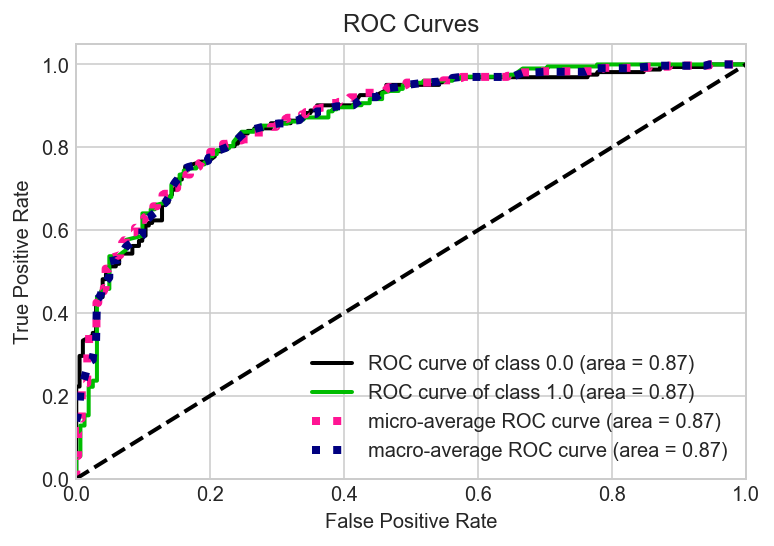

In [279]:
y_pred_proba = LogReg.predict_proba(Xt_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
plt.show()

In [280]:
LogReg.coef_

array([[-0.26532385,  0.13010703, -0.07758503, ..., -0.14492757,
        -0.05221144, -0.09271613]])

In [286]:
coefs = pd.DataFrame({'variable':Title_Train.columns,'coef':list(LogReg.coef_.T),'abs_coef':list(np.abs(LogReg.coef_.T))})

coefs.sort_values('abs_coef', inplace=True, ascending=False)

coefs.head(20)

,abs_coef,coef,variable
2577,[2.210411034392966],[2.210411034392966],senior
359,[1.8729308444402437],[-1.8729308444402437],assistant
1855,[1.5295059222755325],[1.5295059222755325],manager
851,[1.3693778075362597],[-1.3693778075362597],desktop
2465,[1.2150641283293613],[-1.2150641283293613],sales
2061,[1.1630939804924811],[-1.1630939804924811],network infrastructure
154,[1.1590401349396418],[-1.1590401349396418],4k
376,[1.1030234959679934],[-1.1030234959679934],associate
115,[1.0042942337855172],[-1.0042942337855172],3500
210,[0.9953728395881923],[0.9953728395881923],6k


### <font color = blue>Conclusion:
- For BernoulliNB model, the model scores well on training set rather than test set suggesting that there's a high chance of overfitting.
- Meanwhile it's ROC-AUC curve in terms accurately predicting true negatives (TN) and true positives (TP) are just 76.7%.
- As for the Logistic Regression model, the model scores better in ROC-AUC as compared to BernoulliNB, which is 79.7%. In terms of predicting TN and TP, the ROC-AUC curve shows less than 0.05% chance of predicting False Positive labels.
- Job title plays a specific role in determining the low or high salary for the specific position. According to the job coefficients, the top 3 key coefficients are Senior, Assistant and Manager.
- Other than CountVectorizer, I tried to include lemmatization before countvectorizing but to no avail. I think lemmatization would allow for more specific and .isalpha() words. This could also allow me to filter punctuations and more stopwords from the NLTK library.</font>

### <font color = blue>Upsampling: Using SMOTE.</font>
#### <font color = blue>- Model 3: Smote - Logistic Regression with cross-val.</font>

In [98]:
sm = SMOTE(random_state=27, ratio=1.0)
Xsm_train, ysm_train = sm.fit_sample(Xt_train, y_train)

In [103]:
LogReg = LogisticRegression(solver='lbfgs')
kf = KFold (n_splits = 3)
cv_score = cross_val_score(LogReg, Xsm_train, ysm_train, cv = kf)
print ('CV scores = ', cv_score)
print ('CV scores error = ', cv_score.std())
print ('Mean CV scores = ', np.mean(cv_score))

CV scores =  [0.74938575 0.76412776 0.81527094]
CV scores error =  0.028232780068915036
Mean CV scores =  0.7762614831580349


In [104]:
LogReg = LogisticRegression(solver='lbfgs').fit(Xsm_train, ysm_train)

LogR_pred = LogReg.predict(Xt_test)
# Checking accuracy
print ('Accuracy = ', accuracy_score(y_test, LogR_pred))

    
# f1 score
print ('F1 score = ', f1_score(y_test, LogR_pred))

print ('Recall score = ', recall_score(y_test, LogR_pred))

# Checking for true positive and false negatives
print ('ROC-AUC score = ', roc_auc_score(y_test, LogR_pred))

Accuracy =  0.7561643835616438
F1 score =  0.7769423558897244
Recall score =  0.7635467980295566
ROC-AUC score =  0.755230189138235


### <font color = blue>Conclusion:
- As the Logistic Regression model was doing well before upsampling, I figured if upsampling the target variable low or high salary might result in a better accuracy scoring. However, in terms of it's ROC-AUC curve, it dips by about 4% than without upsampling. </font>

#### <font color = blue>Model No.4: Without SMOTE, Logistic Regression with cross-val, multiple features.
- Target variable is set as Low (< SGD 5000) and High (> SGD 5000)
- Features used: Job Level (Raw) which includes entry level, senior and junior positions as well as managers and executives as well as concatenate with Job Title.</font>

In [307]:
X = data1['Level']
y = data1['High or Low Salary']

In [308]:
X_train, X_test, y_train,y_test = train_test_split (X, y, test_size = 0.25, stratify = y)

In [309]:
CV = CountVectorizer(stop_words = 'english', binary = True)
CV.fit(X_train)
Xt1_train = CV.transform (X_train)
Level_train = pd.DataFrame(Xt1_train.todense(), columns = CV.get_feature_names())
Level_train.head()

,entry,executive,junior,manager,senior
0,0,0,1,0,0
1,1,0,0,0,0
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,1,0,0


In [310]:
Xt1_test = CV.transform (X_test)
Level_test = pd.DataFrame(Xt1_test.todense(), columns = CV.get_feature_names())
Level_test.head()

,entry,executive,junior,manager,senior
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


In [311]:
Train_concat = pd.concat([Title_Train, Level_train], axis = 1)
Test_concat = pd.concat([Title_Test, Level_test], axis = 1)
print (Train_concat.shape)
print (Test_concat.shape)
print (y_train.shape)
print (y_test.shape)

(1095, 3144)
(365, 3144)
(1095,)
(365,)


In [312]:
LogReg = LogisticRegression(solver='lbfgs')
kf = KFold (n_splits = 3)
cv_score = cross_val_score(LogReg, Train_concat, y_train, cv = kf)
print ('CV scores = ', cv_score)
print ('CV scores error = ', cv_score.std())
print ('Mean CV scores = ', np.mean(cv_score))

CV scores =  [0.74794521 0.74246575 0.74794521]
CV scores error =  0.0025830384700878868
Mean CV scores =  0.7461187214611873


In [313]:
LogReg1 = LogisticRegression(solver='lbfgs').fit(Train_concat, y_train)

LogR1_pred = LogReg1.predict(Test_concat)
# Checking accuracy
print ('Accuracy = ', accuracy_score(y_test, LogR1_pred))

    
# f1 score
print ('F1 score = ', f1_score(y_test, LogR1_pred))

print ('Recall score = ', recall_score(y_test, LogR1_pred))

# Checking for true positive and false negatives
print ('ROC-AUC score = ', roc_auc_score(y_test, LogR1_pred))

Accuracy =  0.7452054794520548
F1 score =  0.7571801566579636
Recall score =  0.7142857142857143
ROC-AUC score =  0.7491181657848326


In [314]:
cm = confusion_matrix(y_test, LogR1_pred)
tn, fp, fn, tp = confusion_matrix(y_test, LogR1_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  127
False Positives:  35
False Negatives:  58
True Positives:  145


In [315]:
LogReg1.coef_

array([[ 0.17801979,  0.27825372, -0.19392414, ..., -1.00326843,
         2.40376767,  1.55896634]])

In [316]:
coefs = pd.DataFrame({'variable':Train_concat.columns,'coef':list(LogReg1.coef_.T),'abs_coef':list(np.abs(LogReg1.coef_.T))})

coefs.sort_values('abs_coef', inplace=True, ascending=False)

coefs.head(20)

,abs_coef,coef,variable
3142,[2.403767670823112],[2.403767670823112],manager
3139,[2.20560299915448],[-2.20560299915448],entry
3143,[1.5589663357880172],[1.5589663357880172],senior
2582,[1.0869618506915388],[1.0869618506915388],senior data
3141,[1.003268427638266],[-1.003268427638266],junior
1364,[0.9402101999436454],[-0.9402101999436454],executive
380,[0.9300354944108948],[-0.9300354944108948],associate infrastructure
941,[0.9067806972986703],[-0.9067806972986703],electrical
2229,[0.8996166189567203],[-0.8996166189567203],power
2241,[0.858710686248464],[0.858710686248464],presales


#### <font color = blue>Model No.5: Without SMOTE, Random Forest Classifier (ensemble method), multiple features.</font>

In [300]:
from sklearn.ensemble import RandomForestClassifier
from scipy.io import arff

clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(Train_concat, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=1e-07,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [301]:
preds = clf.predict(Test_concat)

pd.crosstab(y_test, preds, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0.0,1.0
Actual Result,,
0.0,122,40
1.0,49,154


In [302]:
print ('Accuracy = ', accuracy_score(y_test, preds))

    
# f1 score
print ('F1 score = ', f1_score(y_test, preds))

print ('Recall score = ', recall_score(y_test, preds))

# Checking for true positive and false negatives
print ('ROC-AUC score = ', roc_auc_score(y_test, preds))

Accuracy =  0.7561643835616438
F1 score =  0.7758186397984886
Recall score =  0.7586206896551724
ROC-AUC score =  0.7558535547041294


In [306]:
list(zip(Train_concat, (clf.feature_importances_)))

[('000', 0.0022025205934348775),
 ('000 000', 0.00020949803964272613),
 ('000 basic', 0.0),
 ('000 central', 0.00044698556516896366),
 ('000 civil', 0.0),
 ('000 infrastructure', 0.0005245396079208414),
 ('000 north', 0.000420408247014321),
 ('000 vb', 0.0009105749591872008),
 ('03_180102', 0.0),
 ('065', 0.00048464042934476525),
 ('10', 0.0),
 ('10 yrs', 2.1605978285399802e-05),
 ('10k', 0.0012747950246739844),
 ('11', 1.0234410766768482e-05),
 ('11 months', 0.0),
 ('1100', 0.0),
 ('1110012001', 0.00029891873331049155),
 ('1110014001', 0.0),
 ('1119', 0.0),
 ('1198007001', 0.0),
 ('1198008001', 0.0),
 ('12', 0.0),
 ('12 month', 0.0),
 ('1213008001', 0.00043367441577064187),
 ('1213010001', 0.0),
 ('12k', 0.0),
 ('12month', 0.0),
 ('12month contract', 0.00017827834842283085),
 ('1319001001', 0.00013225377866805005),
 ('1319002001', 6.183904564914015e-07),
 ('1319003001', 7.1668481004724954e-06),
 ('1320001001', 3.0444560232315925e-07),
 ('1320002001', 0.0),
 ('1320003001', 0.0),
 ('180

### <font color = blue>Conclusion:
- For this section, there were job title and level as the features. 
- Seems like the Logistic Regression is performing 2% better than the random forest classification.
- Manager, Entry, Senior are the top 3 coeffecient variables obtained from the Logistic Regression model. From the model, both the job title and level play a role in determining the salary range as less than or equals to/more than SGD 5000.</font>

## <font color = blue>Qn2: Factors that distinguish job categories.
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?
</font>

In [317]:
data1['Category'].value_counts()

Engineer          1289
Sales               71
Data Scientist      62
Research            21
Others              17
Name: Category, dtype: int64

In [362]:
# Separate input features and target
X = data1['Posting']
y = data1['Category']

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27, stratify = y)

In [364]:
CV = CountVectorizer(stop_words = 'english', strip_accents = 'ascii', ngram_range=(1,2), binary = True)
CV.fit(X_train)
X2_train = CV.transform (X_train)
post_train = pd.DataFrame(X2_train.todense(), columns = CV.get_feature_names())
post_train.head()

,00,00 30,000,000 apply,000 aws,000 basic,000 civil,000 higher,000 month,000 negotiable,...,zones job,zones support,zones translating,zones usa,zookeeper,zookeeper cloudera,zura,zura registration,zuraifah,zuraifah binti
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [365]:
X2_test = CV.transform (X_test)
post_test = pd.DataFrame(X2_test.todense(), columns = CV.get_feature_names())
post_test.head()

,00,00 30,000,000 apply,000 aws,000 basic,000 civil,000 higher,000 month,000 negotiable,...,zones job,zones support,zones translating,zones usa,zookeeper,zookeeper cloudera,zura,zura registration,zuraifah,zuraifah binti
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [366]:
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=10)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf = tfidf_vect.transform(X_test)

In [367]:
sm = SMOTE('minority')
Xsm_train, ysm_train = sm.fit_sample(X2_train,y_train)

#### <font color = blue>Model No.1: SMOTE, Logistic Regression with cross-val.</font>

In [368]:
LogReg = LogisticRegression(solver='lbfgs', multi_class = 'multinomial', max_iter = 500)
kf = KFold (n_splits = 5)
cv_score = cross_val_score(LogReg, Xsm_train, ysm_train, cv = kf)
print ('CV scores = ', cv_score)
print ('CV scores error = ', cv_score.std())
print ('Mean CV scores = ', np.mean(cv_score))

CV scores =  [0.90487805 0.90487805 0.94390244 1.         1.        ]
CV scores error =  0.04267665459141346
Mean CV scores =  0.9507317073170732


In [369]:
LogReg2 = LogisticRegression(solver='lbfgs', multi_class = 'multinomial', max_iter = 500).fit(Xsm_train, ysm_train)

LogR2_pred = LogReg2.predict(X2_test)

# Checking accuracy
print ('Accuracy = ', accuracy_score(y_test, LogR2_pred))

    
# f1 score
print ('F1 score = ', f1_score(y_test, LogR2_pred, average = 'weighted'))

print ('Recall score = ', recall_score(y_test, LogR2_pred, average = 'weighted'))

Accuracy =  0.9178082191780822
F1 score =  0.9202599334918653
Recall score =  0.9178082191780822


In [370]:
LogReg2.coef_

array([[-8.86807364e-05, -8.86807364e-05, -3.82972063e-03, ...,
        -3.32380029e-04, -8.98336490e-04, -8.98336490e-04],
       [ 3.14981247e-04,  3.14981247e-04,  1.00237330e-02, ...,
         6.75491321e-03,  4.58950176e-03,  4.58950176e-03],
       [-8.26733096e-06, -8.26733096e-06, -7.95206881e-03, ...,
        -4.28705054e-03, -2.26352176e-03, -2.26352176e-03],
       [-2.91830823e-05, -2.91830823e-05,  1.97988160e-02, ...,
        -2.26000761e-04, -1.88951955e-04, -1.88951955e-04],
       [-1.88850097e-04, -1.88850097e-04, -1.80407596e-02, ...,
        -1.90948188e-03, -1.23869156e-03, -1.23869156e-03]])

#### <font color = blue>Model No.2: SMOTE, Random Forest Classifier (ensemble method).</font>

In [371]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(Xsm_train, ysm_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=1e-07,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [372]:
preds1 = clf.predict(X2_test)

pd.crosstab(y_test, preds1, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,Data Scientist,Engineer,Others,Research,Sales
Actual Result,,,,,
Data Scientist,1,15,0,0,0
Engineer,0,320,2,0,0
Others,0,3,1,0,0
Research,0,3,0,2,0
Sales,0,15,0,0,3


In [373]:
print ('Accuracy = ', accuracy_score(y_test, preds1))

    
# f1 score
print ('F1 score = ', f1_score(y_test, preds1, average = 'weighted'))

print ('Recall score = ', recall_score(y_test, preds1, average = 'weighted'))

Accuracy =  0.8958904109589041
F1 score =  0.8629534587504538
Recall score =  0.8958904109589041


In [375]:
list(zip(post_train, (clf.feature_importances_)))

[('00', 0.0),
 ('00 30', 0.0),
 ('000', 0.0),
 ('000 apply', 0.0),
 ('000 aws', 0.0),
 ('000 basic', 0.0),
 ('000 civil', 0.0),
 ('000 higher', 0.0),
 ('000 month', 0.0),
 ('000 negotiable', 0.0),
 ('000 people', 0.0),
 ('000 submitting', 0.0),
 ('000 travel', 0.0),
 ('000 vbduration', 0.0),
 ('0005', 0.0),
 ('0005 days', 0.0),
 ('000working', 0.0),
 ('000working location', 0.0),
 ('00am', 0.0),
 ('00am 00pm', 0.0),
 ('00am 00pmfree', 0.0),
 ('00am 30pm', 0.0),
 ('00am 30pmb', 0.0),
 ('00am 30pmfor', 0.0),
 ('00pm', 0.0),
 ('00pm 5800', 0.0),
 ('00pm aws', 0.0),
 ('00pm expo', 0.0),
 ('00pm hr', 0.0),
 ('00pm location', 0.0),
 ('00pm mondays', 0.0),
 ('00pmc', 0.0),
 ('00pmc 00am', 0.0),
 ('00pmfree', 0.0),
 ('00pmfree shuttle', 0.0),
 ('01', 0.0),
 ('01 singapore', 0.0),
 ('01c4394', 0.0),
 ('01c4394 r1654597', 0.0),
 ('02', 0.0),
 ('02 jul', 0.0),
 ('02c3423', 0.0),
 ('02c3423 note', 0.0),
 ('02c3423ea', 0.0),
 ('02c3423ea registration', 0.0),
 ('02c4944ea', 0.0),
 ('02c4944ea regist

### <font color = blue>Conclusion:
- For this section, there were job posting as the feature and job category as the target variables. 
- As this is a multiclass problem, I tried applying Logistic Regression (multi-class - multinomial) and Random forest classifiers (RFC). However I'm still unsure of how to interpret the results.
- In terms of accuracy score, Logisitic Regression won by 2% against RFC which only scored a bout 89.6%.
- As there were too many coefficients (ngram_range set at 1 and 2) I'm unable to determine which coefficients rank the highest. Hence I'm unable to properly determine the factors affecting a job category.</font>

#### <font color = blue>Model No.3: SMOTE, Logistic Regression and multiple features.</font>

In [376]:
X = data1[['Education', 'Level', 'New_Loc']]
y = data1['Category']

In [377]:
X_dummy = pd.get_dummies(X, drop_first = True)
X_dummy.head()

,Education_Comp Science Degree,Education_Comp Vision,Education_Computing,Education_Data Science Experience,Education_Diploma,Education_Engineering,Education_Master's,Education_PhD,Education_Stats Degree,Education_Working Experience,...,Level_Executive,Level_Junior,Level_Manager,Level_Senior,New_Loc_Central,New_Loc_East,New_Loc_North,New_Loc_NorthEast,New_Loc_NorthWest,New_Loc_West
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [378]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=0.25, random_state=27, stratify = y)

In [379]:
sm1 = SMOTE('minority')
Xsm1_train, ysm1_train = sm.fit_sample(X_train,y_train)

In [380]:
print (Xsm1_train.shape)
print (ysm1_train.shape)

(2049, 21)
(2049,)


In [382]:
LogReg = LogisticRegression(solver='lbfgs', multi_class = 'multinomial', max_iter = 500)
kf = KFold (n_splits = 3)
cv_score = cross_val_score(LogReg, Xsm1_train, ysm1_train, cv = kf)
print ('CV scores = ', cv_score)
print ('CV scores error = ', cv_score.std())
print ('Mean CV scores = ', np.mean(cv_score))

CV scores =  [0.71449488 0.84480234 0.7920937 ]
CV scores error =  0.053520312596409006
Mean CV scores =  0.783796974133724


In [383]:
LogReg3 = LogisticRegression(solver='lbfgs', multi_class = 'multinomial', max_iter = 500).fit(Xsm1_train, ysm1_train)

LogR3_pred = LogReg3.predict(X_test)

# Checking accuracy
print ('Accuracy = ', accuracy_score(y_test, LogR3_pred))

    
# f1 score
print ('F1 score = ', f1_score(y_test, LogR3_pred, average = 'weighted'))

print ('Recall score = ', recall_score(y_test, LogR3_pred, average = 'weighted'))

Accuracy =  0.8794520547945206
F1 score =  0.8468670000724794
Recall score =  0.8794520547945206


C:\Users\syami\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### <font color = blue>Model No.4: SMOTE, Random Forest Classification and multiple features.</font>

In [384]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(Xsm1_train, ysm1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=1e-07,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [385]:
preds2 = clf.predict(X_test)

pd.crosstab(y_test, preds2, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,Data Scientist,Engineer,Others,Research,Sales
Actual Result,,,,,
Data Scientist,6,9,1,0,0
Engineer,0,298,22,0,2
Others,0,3,1,0,0
Research,0,4,0,1,0
Sales,0,17,1,0,0


In [386]:
print ('Accuracy = ', accuracy_score(y_test, preds2))

    
# f1 score
print ('F1 score = ', f1_score(y_test, preds2, average = 'weighted'))

print ('Recall score = ', recall_score(y_test, preds2, average = 'weighted'))

Accuracy =  0.8383561643835616
F1 score =  0.8344180929126976
Recall score =  0.8383561643835616


In [387]:
list(zip(X_train, clf.feature_importances_))

[('Education_Comp Science Degree', 0.02530877972216156),
 ('Education_Comp Vision', 0.001771346766191501),
 ('Education_Computing', 0.005617606229256983),
 ('Education_Data Science Experience', 0.013233296646456338),
 ('Education_Diploma', 0.04347064711604643),
 ('Education_Engineering', 0.11485912258107328),
 ("Education_Master's", 0.0003075011012457393),
 ('Education_PhD', 0.008044357944539499),
 ('Education_Stats Degree', 0.014415548672077885),
 ('Education_Working Experience', 0.08578491058111562),
 ('Education_unspecified', 0.13942720234939146),
 ('Level_Executive', 0.005913547705612863),
 ('Level_Junior', 0.11346046439452574),
 ('Level_Manager', 0.07762935158750783),
 ('Level_Senior', 0.1461477742303362),
 ('New_Loc_Central', 0.13836946575250486),
 ('New_Loc_East', 0.02106584997020662),
 ('New_Loc_North', 0.004074854776189062),
 ('New_Loc_NorthEast', 0.015174245035162078),
 ('New_Loc_NorthWest', 0.001090985715131423),
 ('New_Loc_West', 0.02483314112326688)]

### <font color = blue>Conclusion:
- For this section, Education, Job Level and Location (all three were feature engineered) were the features and job category as the target variables. 
- As compared to previous models 1 and 2, models 3 and 4 performed with model 3 having accuracy of 87.9%. However, cross validation suggested that model 3 has higher variance. Hence I think model 4 which is the Random Forest Classification, though only score 83.8% on accuracy, could perform better than model 3.
- Top 3 coefficients which could highly likely impact a Job's Position Title or in this case the category are: Working Experience, Junior and Senior level.</font>